In [1]:
%matplotlib inline

from Utils import *
from modeling import *

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import BasicAer, execute, IBMQ, Aer
from qiskit.compiler import transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.circuit import Gate
from qiskit.quantum_info.operators import Operator

import numpy as np

In [3]:
def state_prep(x):
    backend = Aer.get_backend('unitary_simulator')

    x = normalize_custom(x)

    qreg = QuantumRegister(1)
    qc = QuantumCircuit(qreg)
    # Run the quantum circuit on a unitary simulator backend
    job = execute(qc, backend)
    result = job.result()
    
    U = result.get_unitary(qc)
    S = Operator(U)
    return S


In [50]:
def swap_test(a,b):
    a = normalize_custom(a)
    b = normalize_custom(b)
    
    ancilla = QuantumRegister(1, 'y')
    v1 = QuantumRegister(1, 'v_1')
    v2 = QuantumRegister(1, 'v_2')
    
    c = ClassicalRegister(1, 'c')
    
    qc = QuantumCircuit(v1, v2, ancilla, c)
    
    S1 = state_prep(a)
    qc.unitary(S1, [0], label='$S_{a}$')

    S2 = state_prep(b)
    qc.unitary(S2, [1], label='$S_{b}$')

    qc.barrier()
    
    qc.h(ancilla[0])
    qc.cswap(ancilla[0], v1[0], v2[0])
    qc.h(ancilla[0])
    qc.measure(ancilla[0], c)
    return qc

    

def ensemble_swap_test(x1, x2, x_test):
    n_obs = 2
    d=1
    
    control = QuantumRegister(d, 'd')
    data = QuantumRegister(n_obs, 'x')
    temp = QuantumRegister(1, 'temp')
    data_test = QuantumRegister(1, 'x^{test}')
    avg = QuantumRegister(1, 'f_{i}')
    c = ClassicalRegister(1, 'c')

    qc = QuantumCircuit(control, data, temp, data_test, avg, c)

    S1 = state_prep(x1)
    qc.unitary(S1, [1], label='$S_x$')
    
    S2 = state_prep(x2)
    qc.unitary(S2, [2], label='$S_x$')
    
    S3 = state_prep(x_test)
    qc.unitary(S3, [4], label='$S_{x}$')
    
    qc.h(control)

    qc.barrier()

    qc.cswap(control[0], data[0], temp[0])

    qc.x(control[0])
    qc.cswap(control[0], data[1], temp[0])
    qc.barrier()
    
    
    qc.h(avg[0])
    qc.cswap(avg[0], temp[0], data_test[0])
    qc.h(avg[0])
    qc.measure(avg[0], c)
    return qc

x1 = [np.random.randint(1, 10), np.random.randint(1, 10)]
x2 = [np.random.randint(1, 10), np.random.randint(1, 10)]
x_test = [np.random.randint(1, 10), np.random.randint(1, 10)]

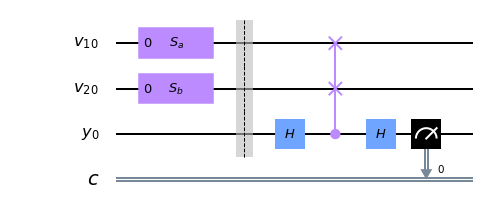

In [31]:
qc = swap_test(x1, x2)
qc.draw(output='mpl')

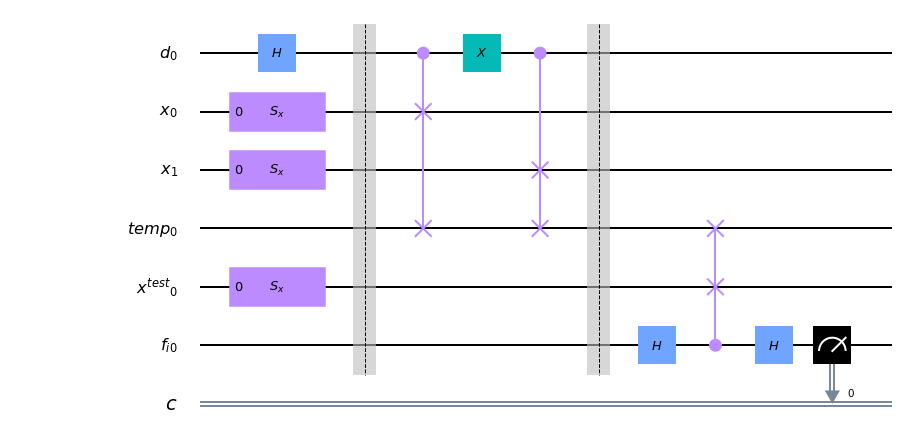

In [51]:
qc = ensemble_swap_test(x1, x2, x_test)
qc.draw(output='mpl', scale=.9)

In [ ]:
x2

In [ ]:
runs = 50
p1_avg = []
p1_ens = []

for run in range(runs):
    # print(run)
    x1 = [np.random.randint(1, 10), np.random.randint(1, 10)]
    x2 = [np.random.randint(1, 10), np.random.randint(1, 10)]
    x_test = [np.random.randint(1, 10), np.random.randint(1, 10)]
    
    swap_x1 = swap_test(x1, x_test)
    r1 = exec_simulator(swap_x1)
    r1 = retrieve_proba(r1)
    
    swap_x2 = swap_test(x2, x_test)
    r2 = exec_simulator(swap_x2)
    r2 = retrieve_proba(r2)    
    
    out = [r1, r2]

    p0 = [p[0] for p in out]
    p1 = [p[1] for p in out]
    
    r_avg = [np.mean(p0), np.mean(p1)]
  
    qc = ensemble_swap_test(x1, x2, x_test)

    r = exec_simulator(qc)
    r_ens = retrieve_proba(r)

    p1_avg.append(r_avg[1])
    p1_ens.append(r_ens[1])


In [ ]:
plt.plot(np.arange(runs), p1_ens, marker='o', color='blue', label='Ens')
plt.plot(np.arange(runs), p1_avg, marker='o', color='orange', label = 'AVG')
plt.title('Comparison: AVG vs Ensemble', size=12).set_position([.5, 1.05])
plt.xlabel('runs', size=12)
plt.ylabel(r'$P(\tilde{y}=1)$', size =12)
plt.xticks(np.arange(0, runs+1, 5), size = 12)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], size = 12)
plt.ylim(-.1,.5)
plt.grid(alpha=.3)
plt.legend()
plt.savefig('output/multi_run.png', dpi = 300)

In [ ]:
qc.draw('mpl')

In [ ]:
# Execution on real device
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
backend = provider.get_backend('ibmq_16_melbourne')
# optimization_level=3

def run_real_device(qc, backend, shots=8192):
    job = execute(qc, backend, shots=shots)
    results = job.result()
    r = results.get_counts(qc)
    return r

In [ ]:
runs = 50
p1_avg = []
p1_ens = []

for run in range(runs):
    # print(run)
    x1 = [np.random.randint(1, 10), np.random.randint(1, 10)]
    x2 = [np.random.randint(1, 10), np.random.randint(1, 10)]
    x_test = [np.random.randint(1, 10), np.random.randint(1, 10)]
    
    swap_x1 = swap_test(x1, x_test)
    r1 = exec_simulator(swap_x1)
    r1 = retrieve_proba(r1)
    
    swap_x2 = swap_test(x2, x_test)
    r2 = exec_simulator(swap_x2)
    r2 = retrieve_proba(r2)    
    
    out = [r1, r2]

    p0 = [p[0] for p in out]
    p1 = [p[1] for p in out]
    
    r_avg = [np.mean(p0), np.mean(p1)]
  
    qc = ensemble_swap_test(x1, x2, x_test)

    r = exec_simulator(qc)
    r_ens = retrieve_proba(r)

    p1_avg.append(r_avg[1])
    p1_ens.append(r_ens[1])
